2023-11-26 14:53:06.775920: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-26 14:53:06.777736: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 14:53:06.801955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 14:53:06.801986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 14:53:06.802612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Epoch 1/10
38/38 [==============================] - 36s 631ms/step - loss: 0.2222 - accuracy: 0.8921 - val_loss: 0.2541 - val_accuracy: 0.8997
Epoch 2/10
38/38 [==============================] - 21s 552ms/step - loss: 0.0651 - accuracy: 0.9757 - val_loss: 0.1432 - val_accuracy: 0.9465
Epoch 3/10
38/38 [==============================] - 20s 550ms/step - loss: 0.0380 - accuracy: 0.9874 - val_loss: 0.1022 - val_accuracy: 0.9599
Epoch 4/10
38/38 [==============================] - 21s 552ms/step - loss: 0.0286 - accuracy: 0.9883 - val_loss: 0.1033 - val_accuracy: 0.9699
Epoch 5/10
38/38 [==============================] - 21s 553ms/step - loss: 0.0124 - accuracy: 0.9967 - val_loss: 0.1037 - val_accuracy: 0.9766
Epoch 6/10
38/38 [==============================] - 22s 579ms/step - loss: 0.0222 - accuracy: 0.9916 - val_loss: 0.2777 - val_accuracy: 0.9298
Epoch 7/10
38/38 [==============================] - 21s 554ms/step - loss: 0.0185 - accuracy: 0.9908 - val_loss: 0.1303 - val_accuracy: 0.9732

/home/hadija/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 8s 107ms/step - loss: 0.0221 - accuracy: 0.9953
Test accuracy: 0.9953145980834961


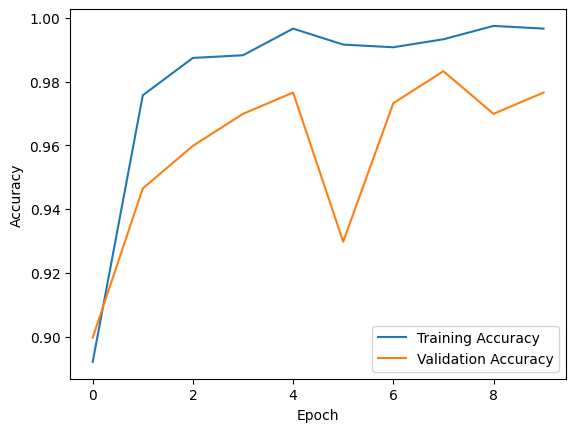

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Load dataset
df = pd.read_csv("SPAM text message 20170820 - Data.csv", index_col=None)

# Preprocess data
df_spam = df[df['Category'] == 'spam']
df_ham = df[df['Category'] == 'ham']
df_ham_down_sample = df_ham.sample(df_spam.shape[0])
df_balanced = pd.concat([df_spam, df_ham_down_sample])
df_balanced['Category'] = df['Category'].map({'spam': 1, 'ham': 0})

sentences = df_balanced["Message"].to_numpy()
labels = df_balanced["Category"].to_numpy()
sentence_len = [len(sentence.split()) for sentence in sentences]
average_sentence_len = round(sum(sentence_len) / len(sentence_len))
np.percentile(sentence_len, 95), average_sentence_len
max_tokens = 10000
max_length = 32
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                                   output_sequence_length=max_length,
                                                   standardize="lower_and_strip_punctuation",
                                                   split="whitespace",
                                                   output_mode="int")
text_vectorizer.adapt(sentences)

# Build neural network model
universal_sentence_encoder = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-large/5',
                                           input_shape=[],
                                           dtype=tf.string,
                                           trainable=False,
                                           name="USE")

model = tf.keras.models.Sequential([
    universal_sentence_encoder,
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
], name="universal_sentence_encoder")

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["accuracy"])

# Train the model
history = model.fit(x=sentences,
                    y=labels,
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])

# Save the model to a file (.h5)
model.save('spam_classifier_model.h5', include_optimizer=True)

# Load the saved model with custom objects
loaded_model = tf.keras.models.load_model('spam_classifier_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

# Evaluate the model
test_loss, test_acc = loaded_model.evaluate(sentences, labels)
print(f'Test accuracy: {test_acc}')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the plot as an image file
plt.savefig('training_history_plot.png')

# Show the plot
plt.show()


In [2]:
%load_ext tensorboard
%tensorboard --logdir=./logs